# Fine Grain Image Classification
> Creating a fine grain image classifier - Pet Breeds!

- toc: true 
- badges: true
- comments: true
- hide: true
- author: Isaac Flath
- categories: [Neural Networks, Image Classification]

# Intro

In this blog we are going to do an image classification to take dog pictures and predict the breed.  This is considered 'fine grain' because the difference between classes is fairly minimal.  Classifying between breeds of dogs is fine grain, classifying whether something is a dog or a cup is not.

To do this we are going to use fastaiv2, which is the new version of fastai that will come out in July.

# Setup

### Library Import and Dataset Download

In [54]:
from fastai2.vision.all import *

seed = 42

# Download and get path for dataseet
path = untar_data(URLs.PETS) #Sample dataset from fastai2
path.ls()

(#2) [Path('/home/ubuntu/.fastai/data/oxford-iiit-pet/images'),Path('/home/ubuntu/.fastai/data/oxford-iiit-pet/annotations')]

In [55]:
img = (path/'images').ls()[0]
img

Path('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/British_Shorthair_154.jpg')

### Data Setup

Data Blocks and data loaders are convenient ways that fastai helps us manage an load data.  There is a lot going on in DataBlock so I am going to break it down piece by piece.


#### DataBlock

+ Blocks:  What is our data?  x is our images (ImageBlock) and y is our categories (CategoryBlock).  In this case each image will get a dog breed as the category.

+ get_items:  How do we get our data (x)?  We use the predefined get_image_files for this, though we can give it something custom if needed.

+ splitter:  How should we create the validation set?  The splitter splits our data into test and validation sets. The default 20% validation set is just fine, but we define a seed so it is reproducable.

+ get_y:  How do we get our dependent variable (y)?  In this care we are going to get it from the file name.  With using_attr, we can apply a function to an attribute of the file (name).  So here we are using regex on the file name to get y.

+ item_tfms:  What transformations do we need to do before packing things up to be sent to the GPU?  In this case resizing it to 460.

+ batch_tfms:  What transformations do we want to do in batches on the GPU?  There are many default transforms, and we are specifying a few ourselves (min_scale and size).



In [56]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
    get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(min_scale = 0.9,size=224)
    )

#### dataloader

The dataloader is what we will actually interact with.  In the DataBlock we defined lots of things we need to do to get and transform images, but not where to get them from.  We define that in the dataloade

In [57]:
dls = pets.dataloaders(path/"images")

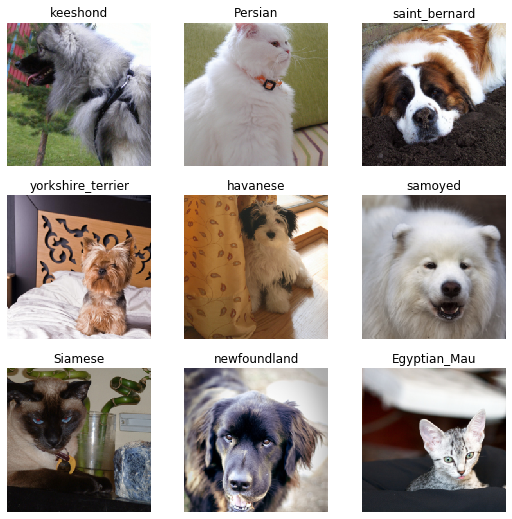

In [58]:
dls.show_batch()

# Training the Model

### Get a basic model working

In 2 lines of code I am going to create and train a basic model.  There's a couple things to note:

1. I am using the dls from the previous step.  This is where we defined how to load the data, how to label it, data augmentation, training/validation split, etc.
2. I can also pass standard architectures.  "Resnet" is a common architecture for image classification.  "34" signifies that it has 34 layers.  If you wish to understand what a layer is, please check out the Image Classifier Basics blog posts that build a simple 1 layer net.
3. I set a metric, but use the default loss metric.

> Note: Loss is what the model uses to train on.  Error rate is just for our reference.  Accuracy and error rates make very poor choices for loss function because they have either 0 or infinite slope, so calculating the gradient/path value/derivative is not meaningful.  This is a prime example of why good functions for computers to understand what's going on and good functions for peope to understand what's going on can be very different things.

In [69]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Next we are going to fine tune the model.

If we were starting from scratch when training a model we will train every layer.  Fine tuning is about training the final layer(s) and leaving the rest intact.  Previous layers were set using weights via transfer learning.  What this means is that a model was trained to be able to detect and classify a bunch of different objects.  The earlier layers of the neural network detect things that are common to lots of images (ie circles, edges, corners, etc.).  These don't need to change much generally.  The last layer is predicting the specific thing, in our case pet breeds.  This is what we need to change.

> Note:  A fun thought expirament on understanding why transfer learning works is to think about elements that you need to identify basically everything that you take for granted, and try to imagininng the world and objects around you if you were missing some basic concepts.  For example, what if you did not have the ability to tell the diference vs a surface and and edge?  Or what if you couldn't tell the difference between something that is straight and curved?  Or what if circular shaped, square shaped objects, and traingular shaped objects all looked the same to you?  What if you could not recognize any pattern - what would you think of a tile floor if you had no ability to comprehend that the tiles are a pattern?  How could you function if you couldn't see corners?

In [70]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.508568,0.304531,0.098106,01:44


epoch,train_loss,valid_loss,error_rate,time
0,0.454936,0.235293,0.079161,02:22
1,0.362131,0.251684,0.081191,02:22
2,0.336058,0.352347,0.120433,02:22
3,0.265309,0.287829,0.087280,02:22
4,0.191693,0.256964,0.070365,02:22
5,0.138121,0.243357,0.067659,02:22
6,0.103806,0.257751,0.073072,02:22
7,0.072458,0.213801,0.063599,02:22
8,0.047542,0.198071,0.060893,02:22
9,0.043064,0.201477,0.060893,02:22


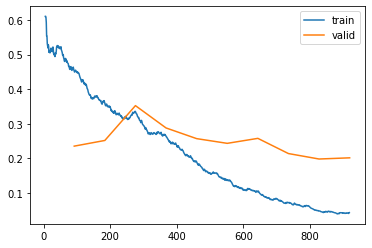

In [71]:
learn.recorder.plot_loss()

We see out validation loss improves significantly with our error rate.  We see validation loss and error rate decreasing for the first few epochs.  Eventually the validation loss and error rate start getting much worse.  This is called 'overfitting'. We will use our lowest validation loss and error rate prior to overfitting as our basline starting point to improve from.

You should be aware that validation loss can increase for 2 reasons.  First, it can get more confident.  Secondly, it can overfit.  If it's the first, keep training.  If you are unsure which it is, save the model and train a couple more epochs.  It'll be aparent then!

> Note: A common misconception is when training loss is lower than validation loss.  This is not the case.  You cannot be overfitting as unless your validation scores get worse.  In a well tuned model, training loss will almost always be lower than validation loss.

Let's take a look at our model, then see if we can improve it!

### Look at results

First lets look at some pictures.  I think it's always good to actually loook at some prediciton the model is making.

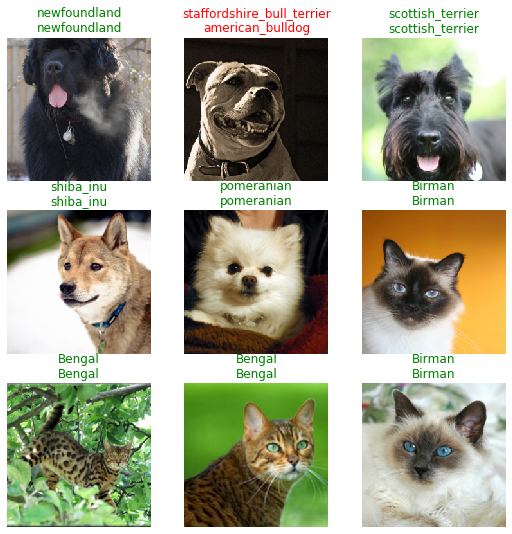

In [19]:
learn.show_results()

Next, we will take a look at some more specif data.  Let's start with a high level confusion matrix.

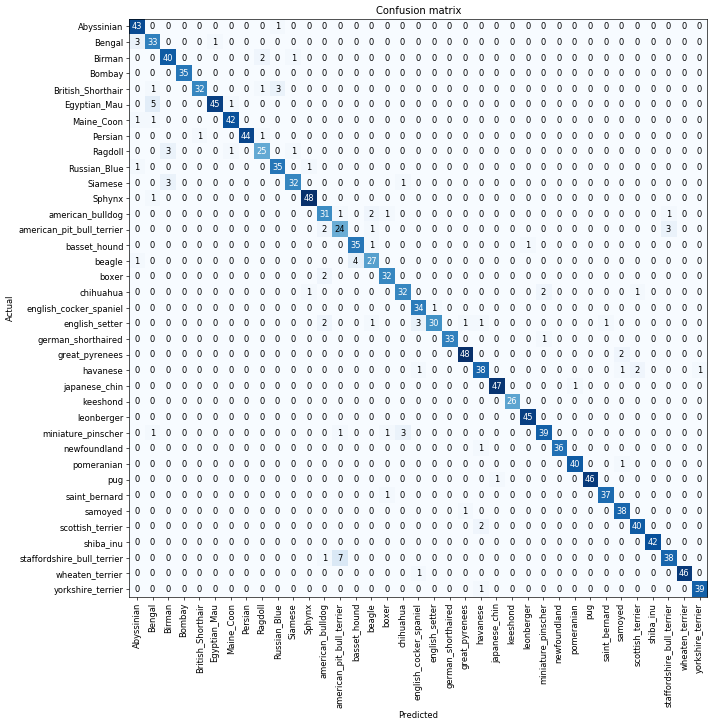

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

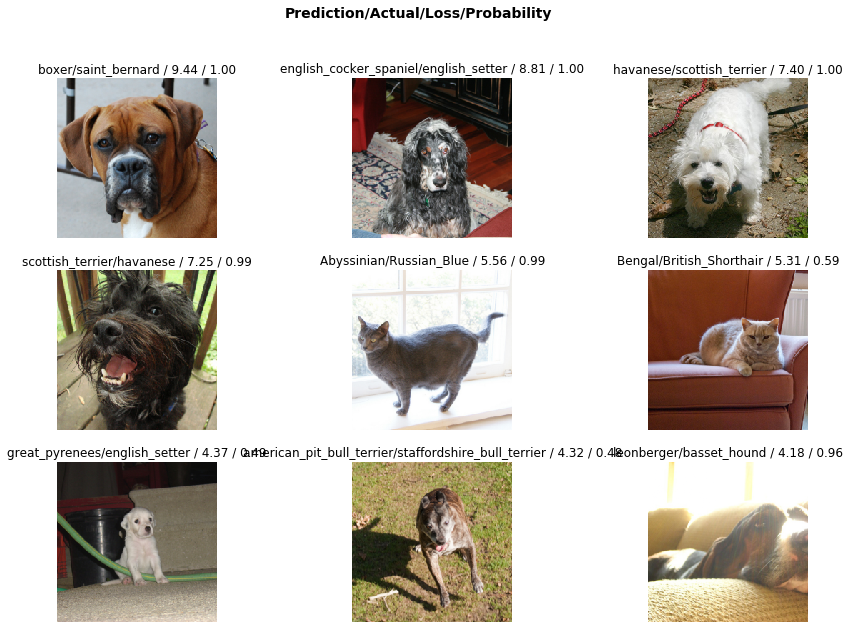

In [21]:
interp.plot_top_losses(9, figsize=(15,10))

In [22]:
interp.most_confused(min_val=3)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Egyptian_Mau', 'Bengal', 5),
 ('beagle', 'basset_hound', 4),
 ('Bengal', 'Abyssinian', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Ragdoll', 'Birman', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('miniature_pinscher', 'chihuahua', 3)]

# Make a Better Model

Now that we have a baseline using the defaults, let's see what we can do to improve it.  We will talk about a few main topics.

+ Freezing and Unfreezing for training
+ Learning Rate Finder
+ Discriminate learning rrate
+ Architecture

### Learning Rate Finder

The Learning Rate Finder is very important because setting a good learning rate can make or break a model.  We will use it multiple times, and it will come up in essentially every deep learning project.  It is good to spend some time to understand what it is showing and expirament.

The learning rate finder (lr_find) gives us 3 things:
+ lr_min:  This is the learning rate that gives us the minimum loss in our graph.  1 common rule of thumb is to divide this by 10 and use that as your learning rate.
+ lr_steep:  This is the steepest point on our graph.  Another rule of thumb is to make this your learning rate.  Interestingly enough, these 2 rules of thumb often end up with very similar results.
+ graph: The graph is really what i use when determining a learning rate.  At the beginning of the graph we see very little reduction in loss.  At the end of the graph we see loss spiking.  Obviously neight of those are good.  In reality we want our learning rate to be somewhere in the middle-ish of that steep decline.  This is in line with our 2 rule of thumbs.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Now that we have our graph, let's train our model with this learning rate.

What's the difference between fine tune and fit one cycle?

In [ ]:
learn.fit_one_cycle(3, 3e-3)

### Unfreezing

Unfreezing a model is about training the full model.  We spoke earlier about fine_tune only training that last layers.  This is a great start and we want to train the last layers more than the early layers, but we still want to train the early layers.  Unfreeze allows us to do this.  Now that we unfroze the model and are going to train the model more, we will need to do our learning rate finder to pick a good learning rate again.

In [ ]:
learn.unfreeze()
learn.lr_find()

### Discriminative Learning Rates

Discriminative Learning Rates means that we are going to use a different learning rate for each layer.  We have previously really been training the final layers of the model.  We are now ready to udate all the weights and biases, including the ones that were set by our transfer learning.  While we do want to train the whole model, we don't want to train it at the same speed.  We want more changes in the end (ie figuring out exactly which breed it is) and less changes in the early layers (ie identifying lines).

We will fit this now for 12 epochs.  The first layers will have 1e-6 learning rate.  The final layers will have 1e-4.  Middle layers will be between those 2 numbers.

In [ ]:
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

In [ ]:
learn.recorder.plot_loss()

# Make an even better model

The general process for creating a good model is to overfit, then reduce overfitting.  Overfitting is defined as continuing to train increases your validation loss.  Once you do that, you run through these steps to reduce overfitting:

+ Get more data if you can
+ Do more meaningful data augmentations if you can
+ Regularization (ie dropout)
+ Model Architecture

Let's start by overfitting a model.  I am going to move to a larger architecture as it was proving extremely difficult to overfit with a resnet 34.  A larger architecture has a larger capacity for accuracy, but a larger capacity to overfit.

In [73]:
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.376186,0.273139,0.100812,02:06
1,0.583618,0.282500,0.090663,02:06
2,0.395882,0.265094,0.086604,02:06


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,error_rate,time
0,0.265648,0.197960,0.064276,02:49
1,0.312412,0.306233,0.084574,02:49
2,0.271075,0.256367,0.073072,02:49
3,0.148258,0.188937,0.057510,02:49
4,0.085290,0.149913,0.048038,02:49
5,0.051177,0.151732,0.050068,02:49


In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn = cnn_learner(dls, resnet101, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.356082,0.254968,0.085927,03:19
1,0.559778,0.242510,0.077131,03:19
2,0.371267,0.244596,0.083221,03:19


epoch,train_loss,valid_loss,error_rate,time
0,0.258089,0.209458,0.064953,04:35
1,0.319197,0.326088,0.093369,04:35
2,0.249428,0.278009,0.080514,04:35
3,0.159397,0.211007,0.058863,04:35
4,0.072370,0.178440,0.049391,04:35


In [ ]:
learn.recorder.plot_loss()